In [2]:
"""
Explore dataset to determine correlations, features, etc.
"""

%load_ext autoreload
%autoreload 2

from PDAC_biomarkers.file_utils import read_csv
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn

# View overall dataset
### Possibly Important Columns:
- `sample_id` - Unique string identifying each subject
- `age` - Patient age in years
- `sex` - Patient sex
- `diagnosis` - 1 = control (no pancreatic disease), 2 = benign hepatobiliary disease (119 of which are chronic pancreatitis); 3 = Pancreatic ductal adenocarcinoma, i.e. pancreatic cancer
- `stage` - cancer stage, mostly NULL
- `benign_sample_diagnosis` - diagnosis for patients with benign diagnosis, mostly NULL
- `creatinine` - creatinine levels, one of the biomarkers
- `LYVE1` - LYVE1 levels, one of the biomarkers
- `REG1B` - REG1B levels, one of the biomarkers
- `TFF1` - TFF1 levels, one of the biomarkers
- `REG1A` - REG1A levels, one of the biomarkers


In [3]:
df = read_csv(Path(r"../data/biomarker_data.csv"))
df

,sample_id,patient_cohort,sample_origin,age,sex,diagnosis,stage,benign_sample_diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,S1,Cohort1,BPTB,33,F,1,NaN,NaN,11.7,1.83222,0.893219,52.948840,654.282174,1262.000
1,S10,Cohort1,BPTB,81,F,1,NaN,NaN,NaN,0.97266,2.037585,94.467030,209.488250,228.407
2,S100,Cohort2,BPTB,51,M,1,NaN,NaN,7.0,0.78039,0.145589,102.366000,461.141000,NaN
3,S101,Cohort2,BPTB,61,M,1,NaN,NaN,8.0,0.70122,0.002805,60.579000,142.950000,NaN
4,S102,Cohort2,BPTB,62,M,1,NaN,NaN,9.0,0.21489,0.000860,65.540000,41.088000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
585,S549,Cohort2,BPTB,68,M,3,IV,NaN,NaN,0.52026,7.058209,156.241000,525.178000,NaN
586,S558,Cohort2,BPTB,71,F,3,IV,NaN,NaN,0.85956,8.341207,16.915000,245.947000,NaN
587,S560,Cohort2,BPTB,63,M,3,IV,NaN,NaN,1.36851,7.674707,289.701000,537.286000,NaN
588,S583,Cohort2,BPTB,75,F,3,IV,NaN,NaN,1.33458,8.206777,205.930000,722.523000,NaN


# Determine missing data

Check to see if any columns have very low entry values (i.e not NaN or None)

### Cols with missing data
- stage
- benign_sample_diagnosis
- plasma_CA19_9
- REG1A

In [4]:
percentages = (df.count() / df.shape[0])
print(percentages)

mask = percentages < .60 # percentage of each column that is non-empty
print("\nColumns with less than 60% of values present\n")
print(*df.loc[:,mask].columns, sep=", ")

sample_id                  1.000000
patient_cohort             1.000000
sample_origin              1.000000
age                        1.000000
sex                        1.000000
diagnosis                  1.000000
stage                      0.337288
benign_sample_diagnosis    0.352542
plasma_CA19_9              0.593220
creatinine                 1.000000
LYVE1                      1.000000
REG1B                      1.000000
TFF1                       1.000000
REG1A                      0.518644
dtype: float64

Columns with less than 60% of values present

stage, benign_sample_diagnosis, plasma_CA19_9, REG1A


# Analysis of difference in biomarker distributions between males and females

No significant differences found

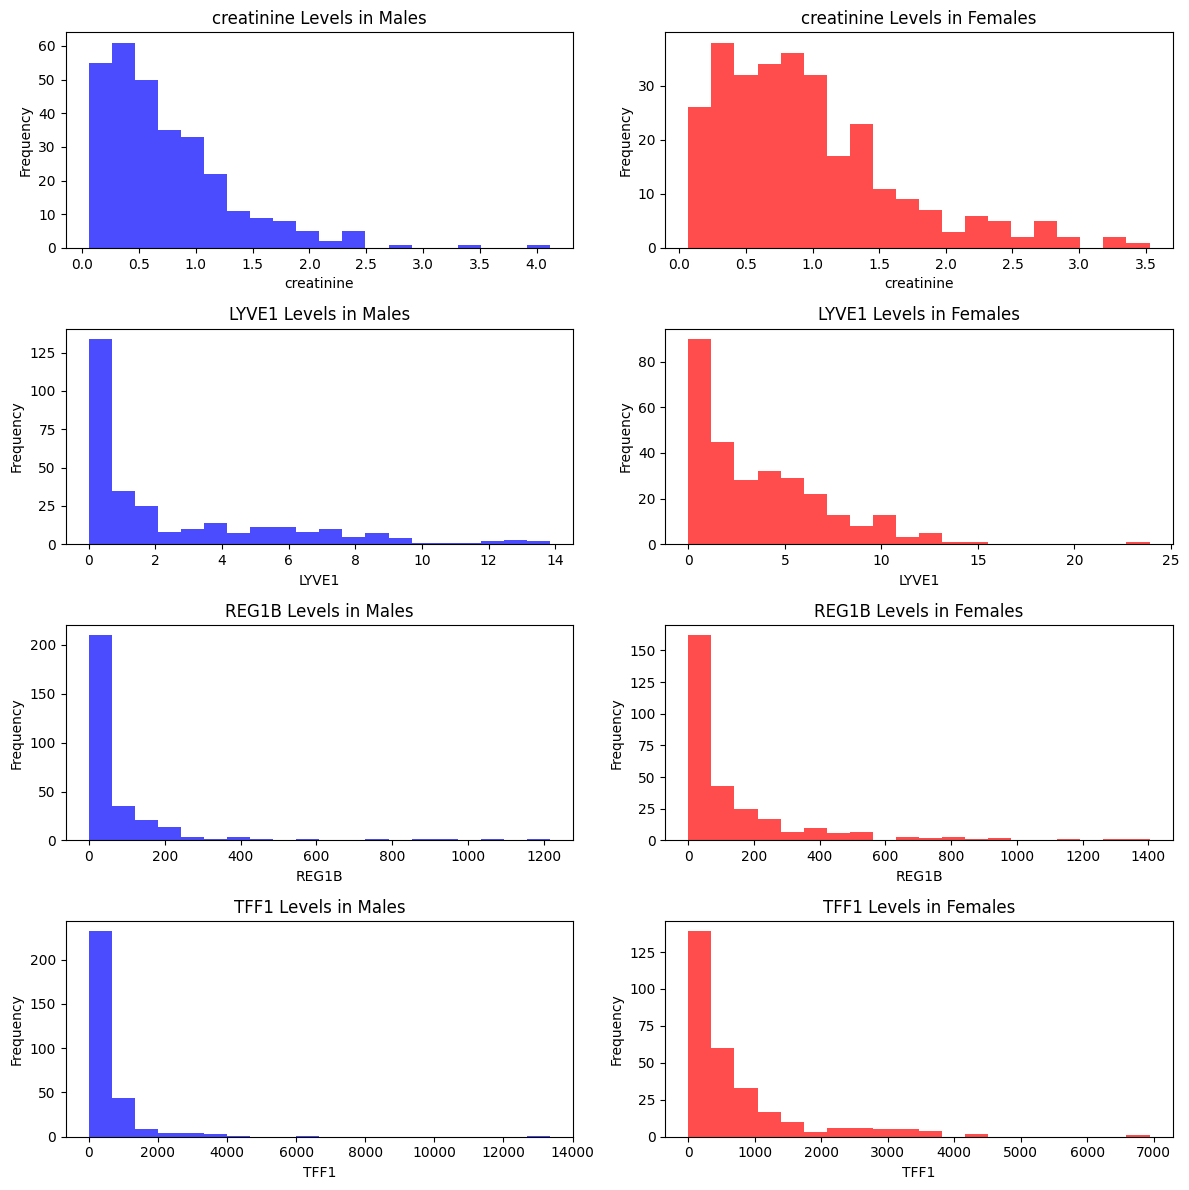

In [5]:
male_data = df.loc[df['sex'] == 'F']
female_data = df.loc[df['sex'] == 'M']

# Plotting histograms of creatinine levels for male and female
plt.figure(figsize=(12,12))

features = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']


for i, feature in enumerate(features):
    # Male data
    plt.subplot(len(features), 2, 2*i+1)
    plt.hist(male_data[feature], bins=20, color='blue', alpha=0.7)
    plt.title(f'{feature} Levels in Males')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

    # Female data
    plt.subplot(len(features), 2, 2*i + 2)
    plt.hist(female_data[feature], bins=20, color='red', alpha=0.7)
    plt.title(f'{feature} Levels in Females')
    plt.xlabel(feature)
    plt.ylabel('Frequency')


plt.tight_layout()

In [39]:
from scipy.stats import ks_2samp

ks_results = {}
for feature in features:
    # Dropping NaN values for a fair comparison
    male_values = male_data[feature].dropna()
    female_values = female_data[feature].dropna()

    # Perform KS test
    ks_stat, p_value = ks_2samp(male_values, female_values)

    # Store the results
    ks_results[feature] = {'KS Statistic': ks_stat, 'p-value': p_value}

print(ks_results)

for feature in ks_results:
    result = ks_results[feature]
    p = result['p-value']
    if p < 0.05:
        print(f"Difference for {feature} sig. btwn males and females with p={p}")
    else:
        print(f"Difference for {feature} NOT sig. btwn males and females with p={p}")


{'creatinine': {'KS Statistic': 0.1909227781034146, 'p-value': 3.418321118780307e-05}, 'LYVE1': {'KS Statistic': 0.24860646599777034, 'p-value': 1.6361074461311627e-08}, 'REG1B': {'KS Statistic': 0.20172625820317439, 'p-value': 9.540374122181575e-06}, 'TFF1': {'KS Statistic': 0.2074612971071958, 'p-value': 4.712246041951941e-06}}
Difference for creatinine sig. btwn males and females with p=3.418321118780307e-05
Difference for LYVE1 sig. btwn males and females with p=1.6361074461311627e-08
Difference for REG1B sig. btwn males and females with p=9.540374122181575e-06
Difference for TFF1 sig. btwn males and females with p=4.712246041951941e-06


# Analysis of difference in biomarker distributions between different age groups

TODO: split up into age strata (maybe use quartiles)

Text(0, 0.5, 'Frequency')

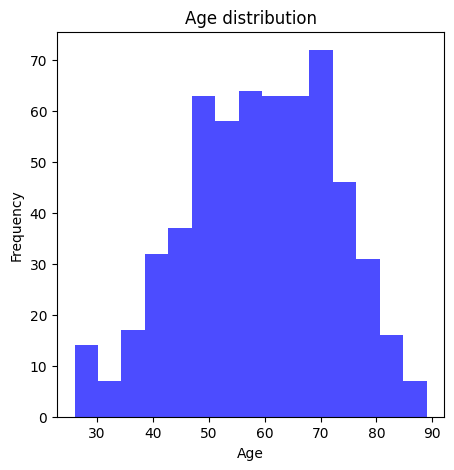

In [7]:
plt.figure(figsize=(5,5))

ages = df['age']

plt.subplot(1, 1, 1)
plt.hist(ages, bins=15, color='blue', alpha=0.7)
plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

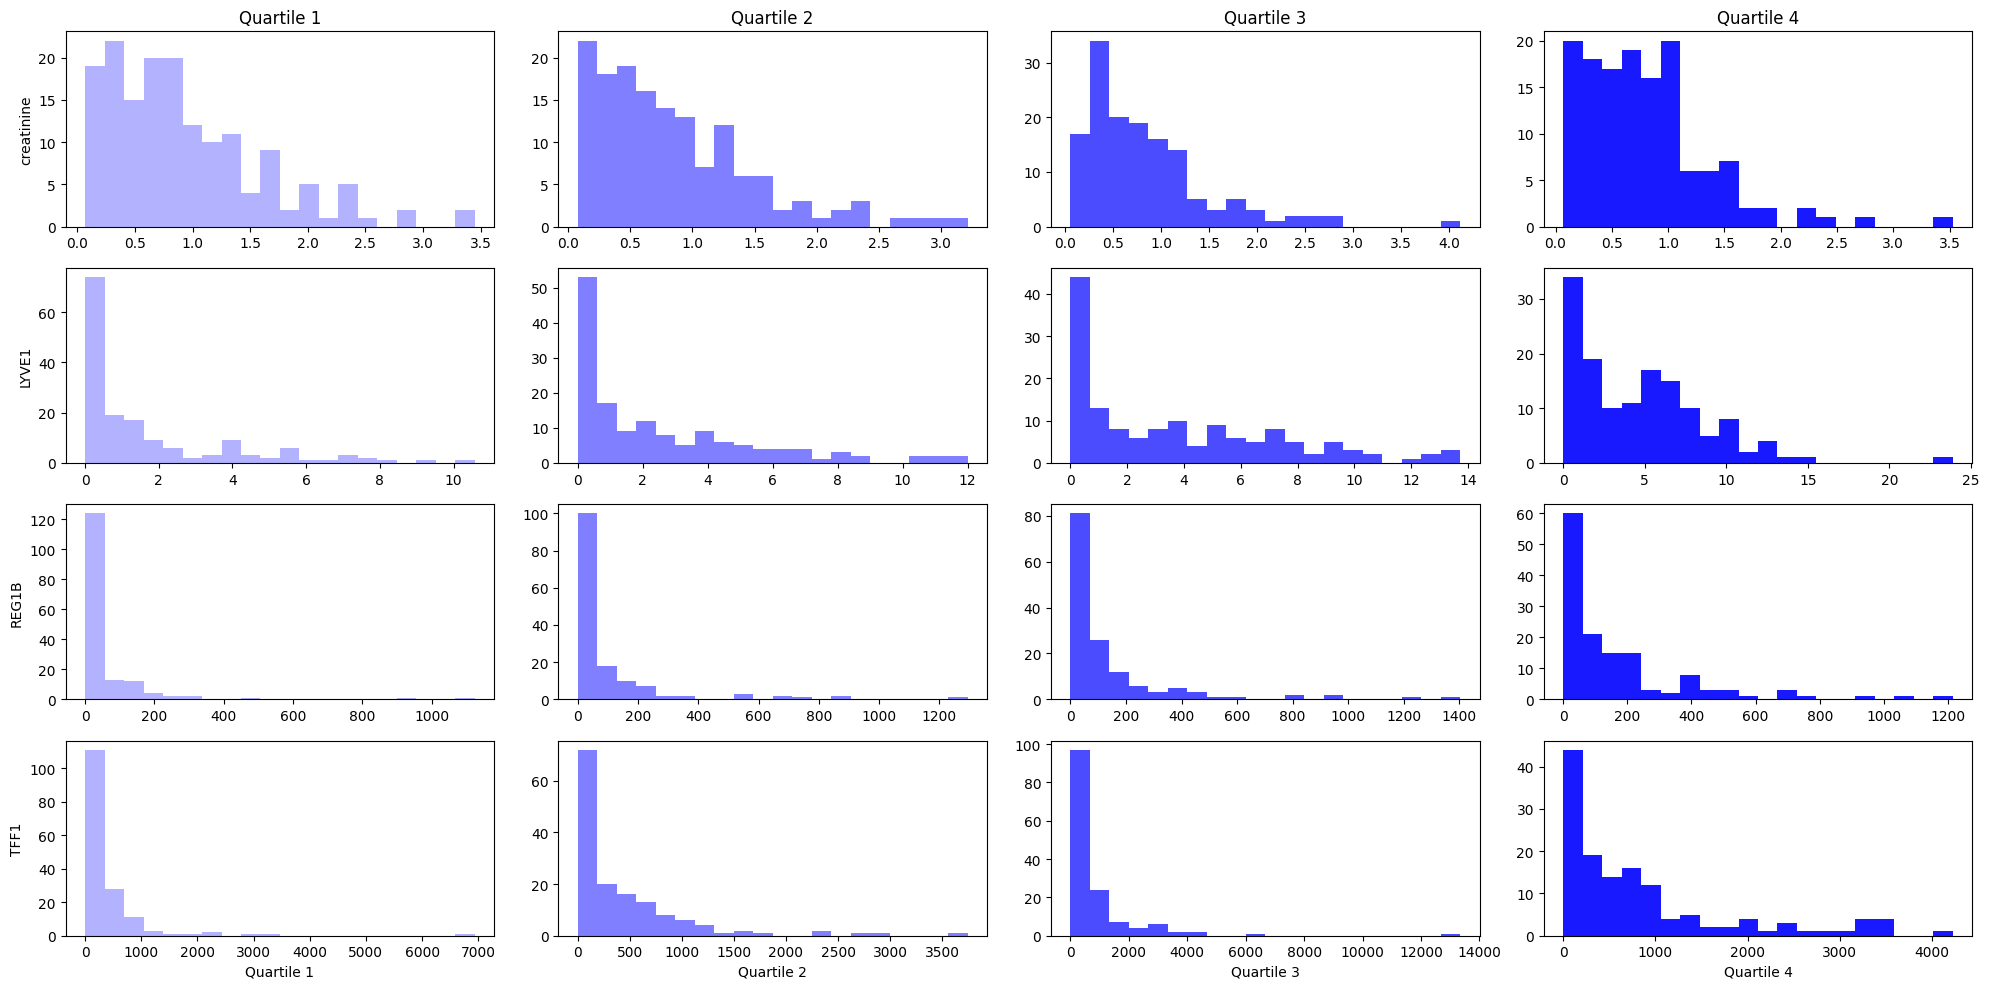

In [35]:
df = pd.read_csv(Path(r"../data/biomarker_data.csv"))
col = 'age'
Q1 = df[col].quantile(0.25)
Q2 = df[col].quantile(0.50)
Q3 = df[col].quantile(0.75)

df_Q1 = df[df[col] <= Q1]
df_Q2 = df[(df[col] > Q1) & (df[col] <= Q2)]
df_Q3 = df[(df[col] > Q2) & (df[col] <= Q3)]
df_Q4 = df[df[col] > Q3]

dfs = [df_Q1, df_Q2, df_Q3, df_Q4]
features = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']

plt.figure(figsize=(20, 10))

for j, feature in enumerate(features):
    for i, df in enumerate(dfs):
        plt.subplot(len(features), len(dfs), j * len(dfs) + i + 1)
        plt.hist(df[feature], bins=20, color='blue', alpha=0.3 + 0.2 * i)
        if i == 0:
            plt.ylabel(feature)
        if j == len(features) - 1:
            plt.xlabel(f'Quartile {i+1}')
        if j == 0:
            plt.title(f'Quartile {i+1}')

plt.tight_layout()
plt.show()


In [44]:
from scipy.stats import f_oneway, tukey_hsd
features = ['creatinine', 'LYVE1', 'REG1B', 'TFF1']
anova_results = {}

for feature in features:
    f_stat, p_val = f_oneway(df_Q1[feature], df_Q2[feature], df_Q3[feature], df_Q4[feature])
    anova_results[feature] = (f_stat, p_val)

print("ANOVA Results (F-statistic and p-value):")
print(anova_results)

ANOVA Results (F-statistic and p-value):
{'creatinine': (1.0118494004455933, 0.3869780674456904), 'LYVE1': (23.7405596634858, 1.6378319078317674e-14), 'REG1B': (8.597696676660012, 1.3603767146949596e-05), 'TFF1': (8.576417644165893, 1.4010690597196702e-05)}


In [45]:
conda create --name my-environment -c conda-forge root

Tukey's HSD test for LYVE1: 
Statistic: [[ 0.         -0.93137528 -2.01972972 -3.00133287]
 [ 0.93137528  0.         -1.08835444 -2.06995759]
 [ 2.01972972  1.08835444  0.         -0.98160315]
 [ 3.00133287  2.06995759  0.98160315  0.        ]]
P-value: [[1.00000000e+00 5.96140636e-02 5.76076343e-07 4.79727369e-13]
 [5.96140636e-02 1.00000000e+00 2.29623344e-02 6.67727012e-07]
 [5.76076343e-07 2.29623344e-02 1.00000000e+00 5.62546027e-02]
 [4.79727369e-13 6.67727012e-07 5.62546027e-02 1.00000000e+00]]
Confidence Intervals: ConfidenceInterval(low=array([[-0.93773349, -1.88792804, -2.98315929, -3.97572332],
       [-0.02517749, -0.97500886, -2.07011084, -3.06247249],
       [ 1.05630014,  0.10659804, -0.98845789, -1.98074738],
       [ 2.02694242,  1.07744269, -0.01754108, -1.00971748]]), high=array([[ 0.93773349,  0.02517749, -1.05630014, -2.02694242],
       [ 1.88792804,  0.97500886, -0.10659804, -1.07744269],
       [ 2.98315929,  2.07011084,  0.98845789,  0.01754108],
       [ 3.975